In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import glob
import numpy as np
from fastai.vision import *
from fastai.layers import *
from fastai.metrics import*
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
pd.set_option('display.max_columns', 500)
import math

In [3]:
class ArcMarginProduct(nn.Module):
  """Implementation of the Arc Margin Product to be suitable for CelebA and VGGFace2.
    CelebA: multi-label classification -> One hot Encoded label
    VGGFace2: Label classification
    Args:
            in_features: size of each input sample (Output of the last layer from the pretrained model)
            out_features: size of each output sample (Number of classes)
            s: norm of input feature (Refer to the paper)
            m: margin (Refer to the paper)
            cos(theta + m)"""
  def __init__(self, in_features, out_features ,s=30.0, m=0.50, easy_margin=False):
    super(ArcMarginProduct,self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(out_features, in_features))
    nn.init.xavier_uniform_(self.weight)
    
  def forward(self,input):
    cosine = F.linear(F.normalize(input), F.normalize(self.weight))
    return cosine

In [4]:
class Customhead():
    """Implementation of the custom head for different model (Resnet34, Resnet50)
    Args:
        num_classes: Number of classes (CelebA: 40, VGGFace2: 9131)
        label: label of the dataset
        p_dropout: drop out ratio
        eps
        momentum
        affine
        track_running_stat
        """
    def __init__(self, num_classes, dataset, p_dropout=0.5, eps=1e-05, momentum=0.1,affine=True, track_running_stats=True):
        super(Customhead, self).__init__()
        self.num_classes = num_classes
        self.p_dropout = p_dropout
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stat = track_running_stats
        self.dataset = dataset
        
    def head(self):
        custom_head = nn.Sequential(
        AdaptiveConcatPool2d(1),
        Flatten(),
        nn.BatchNorm1d(4096, eps=self.eps, momentum=self.momentum, affine=self.affine, track_running_stats=self.track_running_stat),
        nn.Dropout(p=self.p_dropout),
        nn.Linear(in_features=4096, out_features=512, bias=True),
        relu(inplace=True),
        nn.BatchNorm1d(512, eps=self.eps, momentum=self.momentum, affine=self.affine, track_running_stats=self.track_running_stat),
        nn.Dropout(p=self.p_dropout),
        nn.Linear(in_features=512, out_features=512, bias=True),
        ArcMarginProduct(in_features=512,out_features=self.num_classes))
        return custom_head

In [5]:
class ArcfaceLoss(nn.Module):
  """Loss function for Arcface"""
  def __init__(self,s=30.0, m=0.5, dataset='vggface2', loss_type = 'focalloss',easy_margin = False):
    super(ArcfaceLoss,self).__init__()
    self.s = s
    self.m = m
    self.dataset = dataset
    self.easy_margin = easy_margin
    self.cos_m = math.cos(m)
    self.sin_m = math.sin(m)
    self.th = math.cos(math.pi - m)
    self.mm = math.sin(math.pi - m) * m
    self.loss_type = loss_type
    self.cross_loss = nn.CrossEntropyLoss()
    self.gamma = 1
    self.eps = 1e-7
    
  def forward(self,input,label):
    cosine = input
    sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
    phi = cosine * self.cos_m - sine * self.sin_m
    if self.easy_margin:
      phi = torch.where(cosine > 0, phi, cosine)
    else:
      phi = torch.where(cosine > self.th, phi, cosine - self.mm)
    if self.dataset == 'celeba':
      one_hot = self.label
    elif self.dataset == 'vggface2':
      one_hot = torch.zeros(cosine.size(), device='cuda')
      one_hot.scatter_(1,label.view(-1, 1).long(), 1)
    else:
      raise ValueError('Select the dataset - CelebA or VGGFace2')
    output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
    output *= self.s
    
    if self.loss_type == 'focalloss':
      logp = self.cross_loss(output,label)
      p = torch.exp(-logp)
      loss = (1 - p) ** self.gamma * logp
      loss_out = loss.mean()
    else:
      loss_out = self.cross_loss(output,label)
    
    return loss_out

In [6]:
path = '/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100'
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100/n004159/0217_01.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100/n004159/0390_01.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100/n004159/0197_01.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100/n004159/0063_01.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/vggface2/vggface2/train_100/n004159/0166_01.jpg')]

In [7]:
# data = ImageDataBunch.from_folder(path,valid_pst=0.2, bs=64, ds_tfms= get_transforms(),size=224)

In [8]:
pat = '.+\/.+\/(.+)\/.+.jpg'
bs = 64

In [9]:
data = ImageDataBunch.from_name_re(path, fnames, pat, bs=bs, ds_tfms = get_transforms(), size=224)

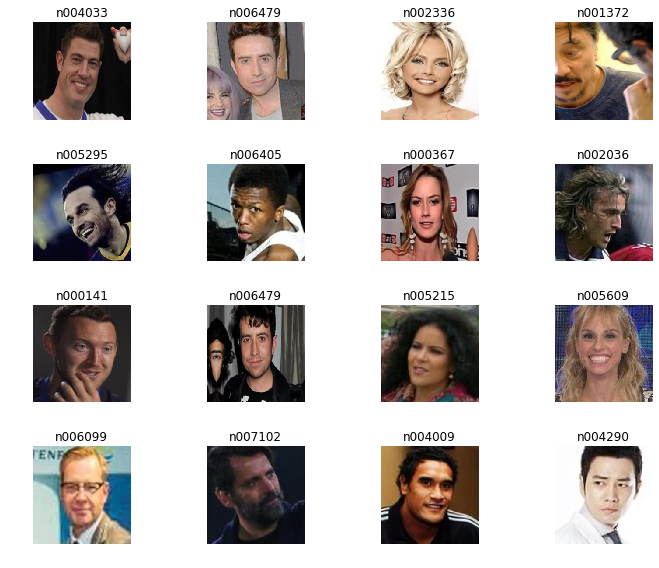

In [10]:
data.show_batch(rows=4, figsize=(10,8))

In [11]:
arch = models.resnet50

In [12]:
arc_face_head = Customhead(num_classes = 100,dataset='vggface2')

In [13]:
custom_loss_func = ArcfaceLoss() 

In [14]:
learn = cnn_learner(data, arch,custom_head=arc_face_head.head(), metrics=[accuracy])

In [15]:
learn.loss_func=custom_loss_func

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


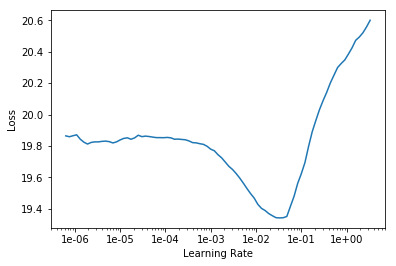

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(1,slice(1e-2/2))

epoch,train_loss,valid_loss,accuracy,time
0,12.971319,10.905771,0.671063,04:46


In [19]:
learn.fit_one_cycle(4, slice(1e-2/2))

epoch,train_loss,valid_loss,accuracy,time
0,11.574887,9.358081,0.698818,04:45
1,9.217859,7.094737,0.747046,04:45
2,8.132869,6.089096,0.769580,04:45
3,7.409875,5.846411,0.779060,04:45


In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


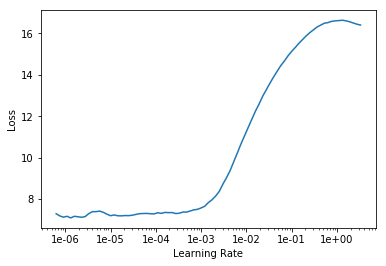

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(1,slice(1e-3/2))

epoch,train_loss,valid_loss,accuracy,time
0,6.377529,4.968569,0.808739,06:15


In [23]:
learn.fit_one_cycle(5,slice(1e-3/2))

epoch,train_loss,valid_loss,accuracy,time
0,5.883980,4.694356,0.814784,06:15
1,5.294658,4.004727,0.828524,06:15
2,4.294539,3.383069,0.849134,06:15
3,3.551172,2.958521,0.863012,06:16
4,3.281745,2.898357,0.867134,06:15


## Infos learner

In [186]:
data.c

100

In [187]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [188]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________

## Heatmap

In [189]:
m = learn.model.eval();

In [194]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

AttributeError: 'list' object has no attribute 'apply_tfms'

In [192]:
xb,_ = data.one_item(x)

AttributeError: 'list' object has no attribute 'apply_tfms'

In [193]:
xb.shape

torch.Size([1, 3, 224, 224])

Add the denorm function do our model and denormalize the image to display it in matplotlib

In [147]:
stats = data.batch_stats();stats

[tensor([0.5203, 0.4302, 0.3849]), tensor([0.2869, 0.2705, 0.2674])]

In [148]:
mean,std = stats
mean,std = tensor(mean),tensor(std)
mean.shape, std.shape, xb.cpu().float().shape

(torch.Size([3]), torch.Size([3]), torch.Size([1, 3, 224, 224]))

In [149]:
def my_denormalize(x:TensorImage, mean:FloatTensor,std:FloatTensor, do_x:bool=True)->TensorImage:
    "Denormalize `x` with `mean` and `std`."
    return x.cpu().float()*std[...,None,None] + mean[...,None,None] if do_x else x.cpu()

In [150]:
data.denorm = partial(my_denormalize,      mean=mean, std=std, do_x=True)

In [151]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [152]:
from fastai.callbacks.hooks import *

In [153]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [154]:
hook_a,hook_g = hooked_backward()

In [155]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 7, 7])

In [156]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [157]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [181]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

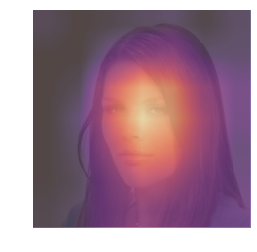

In [182]:
show_heatmap(avg_acts)